In [3]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats


# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 
import shap
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',200)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

# EDA

In [4]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

In [5]:
print(train.shape, test.shape)

(1134555, 9) (537949, 8)


In [6]:
train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.512,0.30256,1.83962,289.066,17.7811,410e86bc0457482d9d6f81cd2d95ccf0,1
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.448,2.13265,-16.28340,159.718,11.5848,6f7bf9104f8c4a619eedd129d5ce3dcb,5


In [7]:
test.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id
0,cb3b5c6ea5e441e9b425fc1e6a4a00e6,23,-86.9773,0.268724,6.699850,87.5486,7.39969,63d5670e5c514f00b64c0329382af524
1,838bf5c3f9bc4a2194f51b3c57f403cd,26,72.0487,-7.242040,-0.515331,73.2549,11.06970,8ddc9b4f189d42d08bde2936914341ed


In [8]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


In [9]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134555 entries, 0 to 1134554
Data columns (total 9 columns):
jet_id                             1134555 non-null object
number_of_particles_in_this_jet    1134555 non-null int64
jet_px                             1134555 non-null float64
jet_py                             1134555 non-null float64
jet_pz                             1134555 non-null float64
jet_energy                         1134555 non-null float64
jet_mass                           1134555 non-null float64
event_id                           1134555 non-null object
label                              1134555 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 77.9+ MB


In [10]:
# 缺失值分析
# all_missing_columns = train.columns[train.isnull().sum() == train.shape[0]]
train.isnull().sum() # 没有缺失值

jet_id                             0
number_of_particles_in_this_jet    0
jet_px                             0
jet_py                             0
jet_pz                             0
jet_energy                         0
jet_mass                           0
event_id                           0
label                              0
dtype: int64

In [11]:
onlyone_val_columns = train.columns[train.nunique(axis=0) == 1]

print('共有 %i 个特征列仅仅只包含一个元素之，' % len(onlyone_val_columns))

print('这些特征列为: ',onlyone_val_columns )

共有 0 个特征列仅仅只包含一个元素之，
这些特征列为:  Index([], dtype='object')


In [12]:
train.describe()

,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,label
count,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06
mean,2.141576e+01,-1.262110e-02,9.496788e-04,1.830779e-03,1.592155e+02,1.357930e+01,8.906894e+00
std,1.226341e+01,2.025569e+02,2.944280e+01,2.802875e+01,1.328982e+02,1.205523e+01,8.340469e+00
min,1.000000e+00,-4.984470e+02,-4.160350e+02,-4.270560e+02,1.004080e+01,-5.642010e-06,1.000000e+00
25%,1.200000e+01,-1.072530e+02,-5.802830e+00,-5.108620e+00,4.049085e+01,4.959175e+00,4.000000e+00
50%,1.900000e+01,1.473780e-01,-1.807420e-03,1.853660e-03,1.198290e+02,1.007730e+01,5.000000e+00
75%,2.800000e+01,1.071365e+02,5.820565e+00,5.157565e+00,2.574340e+02,1.802500e+01,2.100000e+01
max,1.090000e+02,4.987270e+02,4.383140e+02,3.900830e+02,5.003970e+02,1.171720e+02,2.100000e+01


In [13]:
def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
train[train['jet_mass'] < 0].shape # 共有652个值 质量为负， 可以填充为0 或者直接删除
# test[train['jet_mass'] < 0].shape #
train['jet_mass']  = train['jet_mass'].map(lambda x : replace(x))
train['jet_energy']  = train['jet_energy'].map(lambda x : replace(x))

In [14]:
train[train['jet_mass'] < 0].head(100)
# train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [15]:
train.loc[train['jet_mass'] < 0]= 0 

In [16]:
train[train['label'] <= 0].head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [17]:
del train, test
gc.collect()

100

## 特征工程4


In [19]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    print("hanlde column : ", count_column)
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x2'] = data['jet_px'].apply(lambda x : x**2)
    data['y2'] = data['jet_py'].apply(lambda x : x**2)
    data['z2'] = data['jet_pz'].apply(lambda x : x**2)
    data['x+y'] = data['jet_px']+data['jet_py']
    data['x+z'] = data['jet_px']+data['jet_pz']
    data['y+z'] = data['jet_py']+data['jet_pz']
    data['x-y'] = data['jet_px']-data['jet_py']
    data['x-z'] = data['jet_px']-data['jet_pz']
    data['y-z'] = data['jet_py']-data['jet_pz']
    data['x*y'] = data['jet_px']*data['jet_py']
    data['x*z'] = data['jet_px']*data['jet_pz']
    data['y*z'] = data['jet_py']*data['jet_pz']
    data['x/y'] = data['jet_px']/data['jet_py']
    data['x/z'] = data['jet_px']/data['jet_pz']
    data['y/z'] = data['jet_py']/data['jet_pz']
    data['abs'] = data['jet_energy'] - data['energy']
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['number_of_particles_in_this_jet_log1p'] = np.log1p(data['number_of_particles_in_this_jet'])
    
    data['x_energy'] = data['jet_px']/ data['jet_energy']
    data['y_energy'] = data['jet_py']/ data['jet_energy']
    data['z_energy'] = data['jet_pz']/ data['jet_energy']
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    data['x_energy_log1p'] = data['jet_px']/ data['jet_energy_log1p']
    data['y_energy_log1p'] = data['jet_py']/ data['jet_energy_log1p']
    data['z_energy_log1p'] = data['jet_pz']/ data['jet_energy_log1p']
    data['x_mass_log1p'] = data['jet_px']/ data['jet_mass_log1p']
    data['y_mass_log1p'] = data['jet_py']/ data['jet_mass_log1p']
    data['z_mass_log1p'] = data['jet_pz']/ data['jet_mass_log1p']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    data['energy_mass_log1p'] = data['jet_energy_log1p']/ data['jet_mass_log1p']
    
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['mean_jet_energy_log1p'] = data['jet_energy_log1p'] /data['number_of_particles_in_this_jet_log1p']
    data['mean_jet_mass_log1p'] = data['jet_mass_log1p'] /data['number_of_particles_in_this_jet_log1p']
    
    
    # get mean sum std
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x2')
    data = get_mean_sum_std(data, 'event_id', 'y2')
    data = get_mean_sum_std(data, 'event_id', 'z2')
    data = get_mean_sum_std(data, 'event_id', 'x+y')
    data = get_mean_sum_std(data, 'event_id', 'x+z')
    data = get_mean_sum_std(data, 'event_id', 'y+z')
    data = get_mean_sum_std(data, 'event_id', 'x-y')
    data = get_mean_sum_std(data, 'event_id', 'x-z')
    data = get_mean_sum_std(data, 'event_id', 'y-z')
    data = get_mean_sum_std(data, 'event_id', 'x*y')
    data = get_mean_sum_std(data, 'event_id', 'x*z')
    data = get_mean_sum_std(data, 'event_id', 'y*z')
    data = get_mean_sum_std(data, 'event_id', 'x/y')
    data = get_mean_sum_std(data, 'event_id', 'x/z')
    data = get_mean_sum_std(data, 'event_id', 'y/z')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet_log1p')

    
    data = get_mean_sum_std(data, 'event_id', 'x_energy')
    data = get_mean_sum_std(data, 'event_id', 'y_energy')
    data = get_mean_sum_std(data, 'event_id', 'z_energy')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
    data = get_mean_sum_std(data, 'event_id', 'x_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'y_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'z_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'y_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'z_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass_log1p')
    
    # event_jet_num 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
  
    return data

data_new = get_feature(data)


data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)
hanlde column :  jet_px
hanlde column :  jet_py
hanlde column :  jet_pz
hanlde column :  number_of_particles_in_this_jet
hanlde column :  jet_mass
hanlde column :  jet_energy
hanlde column :  energy
hanlde column :  x2
hanlde column :  y2
hanlde column :  z2
hanlde column :  x+y
hanlde column :  x+z
hanlde column :  y+z
hanlde column :  x-y
hanlde column :  x-z
hanlde column :  y-z
hanlde column :  x*y
hanlde column :  x*z
hanlde column :  y*z
hanlde column :  x/y
hanlde column :  x/z
hanlde column :  y/z
hanlde column :  abs
hanlde column :  jet_energy_log1p
hanlde column :  jet_mass_log1p
hanlde column :  number_of_particles_in_this_jet_log1p
hanlde column :  x_energy
hanlde column :  y_energy
hanlde column :  z_energy
hanlde column :  x_mass
hanlde column :  y_mass
hanlde column :  z_mass
hanlde column :  x_energy_log1p
hanlde column :  y_energy_log1p
hanlde column :  z_energy_log1p
hanlde column :  x_mass_log1p
hanlde column :

In [41]:
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)


d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

res = train.columns.tolist()

print(res)

(1134555, 180) (537949, 180)
['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x2', 'y2', 'z2', 'x+y', 'x+z', 'y+z', 'x-y', 'x-z', 'y-z', 'x*y', 'x*z', 'y*z', 'x/y', 'x/z', 'y/z', 'abs', 'jet_energy_log1p', 'jet_mass_log1p', 'number_of_particles_in_this_jet_log1p', 'x_energy', 'y_energy', 'z_energy', 'x_mass', 'y_mass', 'z_mass', 'x_energy_log1p', 'y_energy_log1p', 'z_energy_log1p', 'x_mass_log1p', 'y_mass_log1p', 'z_mass_log1p', 'energy_mass', 'energy_mass_log1p', 'mean_jet_energy', 'mean_jet_mass', 'mean_jet_energy_log1p', 'mean_jet_mass_log1p', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_

In [22]:
print(train.columns.to_list())


['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x2', 'y2', 'z2', 'x+y', 'x+z', 'y+z', 'x-y', 'x-z', 'y-z', 'x*y', 'x*z', 'y*z', 'x/y', 'x/z', 'y/z', 'abs', 'jet_energy_log1p', 'jet_mass_log1p', 'number_of_particles_in_this_jet_log1p', 'x_energy', 'y_energy', 'z_energy', 'x_mass', 'y_mass', 'z_mass', 'x_energy_log1p', 'y_energy_log1p', 'z_energy_log1p', 'x_mass_log1p', 'y_mass_log1p', 'z_mass_log1p', 'energy_mass', 'energy_mass_log1p', 'mean_jet_energy', 'mean_jet_mass', 'mean_jet_energy_log1p', 'mean_jet_mass_log1p', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_

In [44]:
train_features =['jet_energy', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'number_of_particles_in_this_jet', 'energy', 'x2', 'y2', 'z2', 'x+y', 'x+z', 'y+z', 'x-y', 'x-z', 'y-z', 'x*y', 'x*z', 'y*z', 'x/y', 'x/z', 'y/z', 'abs', 'jet_energy_log1p', 'jet_mass_log1p', 'number_of_particles_in_this_jet_log1p', 'x_energy', 'y_energy', 'z_energy', 'x_mass', 'y_mass', 'z_mass', 'x_energy_log1p', 'y_energy_log1p', 'z_energy_log1p', 'x_mass_log1p', 'y_mass_log1p', 'z_mass_log1p', 'energy_mass', 'energy_mass_log1p', 'mean_jet_energy', 'mean_jet_mass', 'mean_jet_energy_log1p', 'mean_jet_mass_log1p', 'event_id_jet_px_mean',
                 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 
                 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 
                 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 
                 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std',
                 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x2_mean', 
                 'event_id_x2_std', 'event_id_x2_sum', 'event_id_y2_mean', 'event_id_y2_std', 'event_id_y2_sum', 'event_id_z2_mean', 
                 'event_id_z2_std', 'event_id_z2_sum', 'event_id_x+y_mean', 'event_id_x+y_std', 'event_id_x+y_sum', 'event_id_x+z_mean', 
                 'event_id_x+z_std', 'event_id_x+z_sum', 'event_id_y+z_mean', 'event_id_y+z_std', 'event_id_y+z_sum', 'event_id_x-y_mean', 
                 'event_id_x-y_std', 'event_id_x-y_sum', 'event_id_x-z_mean', 'event_id_x-z_std', 'event_id_x-z_sum', 'event_id_y-z_mean', 
                 'event_id_y-z_std', 'event_id_y-z_sum', 'event_id_x*y_mean', 'event_id_x*y_std', 'event_id_x*y_sum', 'event_id_x*z_mean', 
                 'event_id_x*z_std', 'event_id_x*z_sum', 'event_id_y*z_mean', 'event_id_y*z_std', 'event_id_y*z_sum', 'event_id_x/y_mean', 
                 'event_id_x/y_std', 'event_id_x/y_sum', 'event_id_x/z_mean', 'event_id_x/z_std', 'event_id_x/z_sum', 'event_id_y/z_mean', 
                 'event_id_y/z_std', 'event_id_y/z_sum', 'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum', 
                 'event_id_jet_energy_log1p_mean', 'event_id_jet_energy_log1p_std', 'event_id_jet_energy_log1p_sum', 
                 'event_id_jet_mass_log1p_mean', 'event_id_jet_mass_log1p_std', 'event_id_jet_mass_log1p_sum',
                 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_number_of_particles_in_this_jet_log1p_std',
                 'event_id_number_of_particles_in_this_jet_log1p_sum', 'event_id_x_energy_mean', 'event_id_x_energy_std', 
                 'event_id_x_energy_sum', 'event_id_y_energy_mean', 'event_id_y_energy_std', 'event_id_y_energy_sum', 
                 'event_id_z_energy_mean', 'event_id_z_energy_std', 'event_id_z_energy_sum', 'event_id_x_mass_mean', 
                 'event_id_x_mass_std', 'event_id_x_mass_sum', 'event_id_y_mass_mean', 'event_id_y_mass_std',
                 'event_id_y_mass_sum', 'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum', 
                 'event_id_x_energy_log1p_mean', 'event_id_x_energy_log1p_std', 'event_id_x_energy_log1p_sum', 'event_id_y_energy_log1p_mean',
                 'event_id_y_energy_log1p_std', 'event_id_y_energy_log1p_sum', 'event_id_z_energy_log1p_mean', 
                 'event_id_z_energy_log1p_std', 'event_id_z_energy_log1p_sum', 'event_id_x_mass_log1p_mean', 'event_id_x_mass_log1p_std', 
                 'event_id_x_mass_log1p_sum', 'event_id_y_mass_log1p_mean', 'event_id_y_mass_log1p_std', 'event_id_y_mass_log1p_sum',
                 'event_id_z_mass_log1p_mean', 'event_id_z_mass_log1p_std', 'event_id_z_mass_log1p_sum', 'event_id_energy_mass_mean',
                 'event_id_energy_mass_std', 'event_id_energy_mass_sum', 'event_id_energy_mass_log1p_mean', 
                 'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum', 'event_id_mean_jet_energy_mean', 
                 'event_id_mean_jet_energy_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean', 
                 'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum', 'event_id_mean_jet_energy_log1p_mean', 
                 'event_id_mean_jet_energy_log1p_std', 'event_id_mean_jet_energy_log1p_sum', 'event_id_mean_jet_mass_log1p_mean', 
                 'event_id_mean_jet_mass_log1p_std', 'event_id_mean_jet_mass_log1p_sum', 'event_jet_num']

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
kf = KFold(n_splits=folds) 
results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
#     print("*" * 50)
#     print("lightgbm 训练")
#     params = {
#             'boosting_type': 'gbdt',
#             'objective': 'multiclass',
#             'num_class':4,
#             'metric': {'multi_logloss'},
#             'subsample': 0.25,
#             'subsample_freq': 1,
#             'learning_rate': 0.05,
#             'num_leaves': 20,
#             'feature_fraction': 0.9,
#             'lambda_l1': 3,  
#             'lambda_l2': 3
#             }
#     ## Lightgbm
#     lgb_model = lgb.train(params, 
#             train_set = lgb.Dataset(X_train, Y_train), 
#             valid_sets = [lgb.Dataset(X_train, Y_train), 
#                 lgb.Dataset(X_valid, Y_valid)],
#             num_boost_round=800, 
#             verbose_eval=50, 
#             early_stopping_rounds=50
#     )
#     lgb_pred= lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#     lgb_pred = lgb_pred.argmax(axis=1)

#     print('lightgbm 分类报告：\n',classification_report(Y_valid , lgb_pred))
#     results += lgb_model.predict(test[train_features],  num_iteration=lgb_model.best_iteration)
    
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=2000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.02, 
        max_depth=8, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))
 
    results += cat_model.predict_proba(test[train_features])
     
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1223-01.csv', index=False)
#0.701358554193129






0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5165715	test: 0.5143999	best: 0.5143999 (0)	total: 65.8ms	remaining: 2m 11s
200:	learn: 0.5607870	test: 0.5575931	best: 0.5575931 (200)	total: 11s	remaining: 1m 38s
400:	learn: 0.5693829	test: 0.5661735	best: 0.5661735 (400)	total: 21.7s	remaining: 1m 26s
600:	learn: 0.5756144	test: 0.5711490	best: 0.5711490 (600)	total: 32.3s	remaining: 1m 15s
800:	learn: 0.5811992	test: 0.5748994	best: 0.5748994 (800)	total: 42.7s	remaining: 1m 3s
1000:	learn: 0.5859114	test: 0.5784294	best: 0.5784294 (1000)	total: 53.3s	remaining: 53.2s
1200:	learn: 0.5906798	test: 0.5817876	best: 0.5817920 (1199)	total: 1m 3s	remaining: 42.5s
1400:	learn: 0.5951133	test: 0.5852074	best: 0.5852074 (1400)	total: 1m 14s	remaining: 31.8s
1600:	learn: 0.5991182	test: 0.5884113	best: 0.5884113 (1600)	total: 1m 25s	remaining: 21.2s
1800:	learn: 0.6034679	test: 0.5914786	best: 0.5914786 (1800)	total: 1m 36s	remaining: 10.6s
1999:	learn





1it [01:55, 115.67s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5155788	test: 0.5162156	best: 0.5162156 (0)	total: 65.9ms	remaining: 2m 11s
200:	learn: 0.5598395	test: 0.5602020	best: 0.5602020 (200)	total: 10.9s	remaining: 1m 37s
400:	learn: 0.5692904	test: 0.5681831	best: 0.5682007 (398)	total: 21.4s	remaining: 1m 25s
600:	learn: 0.5752663	test: 0.5730529	best: 0.5730529 (600)	total: 32.3s	remaining: 1m 15s
800:	learn: 0.5806054	test: 0.5772704	best: 0.5772968 (797)	total: 43.2s	remaining: 1m 4s
1000:	learn: 0.5853892	test: 0.5806550	best: 0.5806638 (999)	total: 53.9s	remaining: 53.8s
1200:	learn: 0.5900243	test: 0.5843348	best: 0.5843348 (1200)	total: 1m 4s	remaining: 43s
1400:	learn: 0.5944280	test: 0.5876665	best: 0.5876665 (1400)	total: 1m 15s	remaining: 32.2s
1600:	learn: 0.5984593	test: 0.5903945	best: 0.5904650 (1598)	total: 1m 25s	remaining: 21.3s
1800:	learn: 0.6029941	test: 0.5935146	best: 0.5935146 (1798)	total: 1m 36s	remaining: 10.7s
1999:	learn:





2it [03:51, 115.78s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5161748	test: 0.5162156	best: 0.5162156 (0)	total: 70.4ms	remaining: 2m 20s
200:	learn: 0.5604356	test: 0.5590959	best: 0.5590959 (200)	total: 11.1s	remaining: 1m 39s
400:	learn: 0.5696969	test: 0.5676367	best: 0.5676499 (397)	total: 22s	remaining: 1m 27s
600:	learn: 0.5752894	test: 0.5722596	best: 0.5723213 (596)	total: 32.6s	remaining: 1m 15s
800:	learn: 0.5805878	test: 0.5764771	best: 0.5764903 (798)	total: 43.3s	remaining: 1m 4s
1000:	learn: 0.5855842	test: 0.5807123	best: 0.5807123 (1000)	total: 53.9s	remaining: 53.8s
1200:	learn: 0.5901862	test: 0.5840836	best: 0.5841145 (1199)	total: 1m 4s	remaining: 42.9s
1400:	learn: 0.5946561	test: 0.5871906	best: 0.5872743 (1397)	total: 1m 15s	remaining: 32.1s
1600:	learn: 0.5991137	test: 0.5901962	best: 0.5901962 (1600)	total: 1m 25s	remaining: 21.3s
1800:	learn: 0.6037841	test: 0.5933295	best: 0.5933295 (1799)	total: 1m 36s	remaining: 10.6s
1999:	learn





3it [05:46, 115.57s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5158586	test: 0.5163346	best: 0.5163346 (0)	total: 70ms	remaining: 2m 19s
200:	learn: 0.5596798	test: 0.5610129	best: 0.5610394 (199)	total: 11.6s	remaining: 1m 43s
400:	learn: 0.5690844	test: 0.5691923	best: 0.5691923 (400)	total: 22.1s	remaining: 1m 28s
600:	learn: 0.5752707	test: 0.5736610	best: 0.5736610 (600)	total: 32.6s	remaining: 1m 15s
800:	learn: 0.5805801	test: 0.5774643	best: 0.5774643 (800)	total: 43.2s	remaining: 1m 4s
1000:	learn: 0.5853936	test: 0.5813821	best: 0.5813953 (999)	total: 53.6s	remaining: 53.5s
1200:	learn: 0.5899053	test: 0.5847271	best: 0.5847271 (1200)	total: 1m 4s	remaining: 42.7s
1400:	learn: 0.5943498	test: 0.5879574	best: 0.5879882 (1399)	total: 1m 14s	remaining: 31.9s
1600:	learn: 0.5987149	test: 0.5911437	best: 0.5911437 (1600)	total: 1m 25s	remaining: 21.2s
1800:	learn: 0.6031451	test: 0.5944049	best: 0.5944489 (1796)	total: 1m 35s	remaining: 10.6s
1999:	learn:





4it [07:41, 115.30s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5166861	test: 0.5147525	best: 0.5147525 (0)	total: 65.6ms	remaining: 2m 11s
200:	learn: 0.5604675	test: 0.5579941	best: 0.5579941 (200)	total: 11s	remaining: 1m 38s
400:	learn: 0.5697663	test: 0.5653362	best: 0.5653538 (393)	total: 21.4s	remaining: 1m 25s
600:	learn: 0.5758833	test: 0.5706246	best: 0.5706378 (599)	total: 32s	remaining: 1m 14s
800:	learn: 0.5812014	test: 0.5752828	best: 0.5752828 (800)	total: 42.8s	remaining: 1m 4s
1000:	learn: 0.5860888	test: 0.5792844	best: 0.5792844 (1000)	total: 53.3s	remaining: 53.2s
1200:	learn: 0.5901245	test: 0.5821181	best: 0.5821357 (1197)	total: 1m 4s	remaining: 42.7s
1400:	learn: 0.5945800	test: 0.5852647	best: 0.5852647 (1399)	total: 1m 14s	remaining: 32.1s
1600:	learn: 0.5989639	test: 0.5883276	best: 0.5883276 (1600)	total: 1m 25s	remaining: 21.4s
1800:	learn: 0.6031274	test: 0.5916593	best: 0.5916769 (1799)	total: 1m 36s	remaining: 10.7s
1999:	learn: 





5it [09:37, 115.58s/it]


**catboost特征重要性**

feature_ len 177
[0.00000000e+00 1.01771087e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.02064709e-01 1.69190327e-03 2.33961730e-02
 2.52432102e-01 2.66442810e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08597825e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.76529323e-01 6.66954065e-03
 1.13569682e-02 8.64810684e-02 1.88904766e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.00352298e-02 1.04974398e-01
 1.92588694e-02 1.26806577e-01 4.38378141e-03 6.36459369e-02
 3.85889702e+00 1.24429772e-01 5.03814375e+00 3.55995228e-01
 1.07768777e-01 3.72478568e-01 3.71945295e-01 6.56914019e-02
 1.42844689e-01 4.80191599e+00 2.69565968e+00 6.90011071e+00
 2.88165487e-01 2.99850717e-01 1.07682483e-01 3.86547496e-02
 3.82821040e-01 1.97289982e-01 3.07989854e-02 2.62756962e-01
 1.2432

[('event_id_x_mass_std', 9.364722630468366), ('event_id_number_of_particles_in_this_jet_sum', 6.900110714717568), ('event_id_jet_px_sum', 5.038143750704276), ('event_id_number_of_particles_in_this_jet_mean', 4.80191599359771), ('event_id_mean_jet_energy_std', 4.472482777644615), ('event_id_x/z_std', 4.023572984825212), ('event_id_jet_px_mean', 3.858897019787962), ('event_id_mean_jet_energy_log1p_mean', 3.6576518333088357), ('event_id_x/y_std', 3.577652109774648), ('event_id_mean_jet_mass_mean', 2.881760648537703), ('event_id_number_of_particles_in_this_jet_std', 2.695659675687111), ('event_id_energy_mass_std', 2.0838503795297094), ('event_id_mean_jet_energy_log1p_std', 1.8850757901823023), ('event_id_mean_jet_mass_std', 1.4547736454798743), ('event_id_energy_mass_log1p_mean', 1.2339078673587505), ('event_id_z_mass_std', 1.1735329303279667), ('event_id_number_of_particles_in_this_jet_log1p_std', 1.1193718959979013), ('event_id_abs_mean', 1.1179802135273786), ('event_id_abs_sum', 0.98232

 catboost 重要性 > 0.0 特征类别： 151 ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_px_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_mean_jet_energy_std', 'event_id_x/z_std', 'event_id_jet_px_mean', 'event_id_mean_jet_energy_log1p_mean', 'event_id_x/y_std', 'event_id_mean_jet_mass_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_energy_mass_std', 'event_id_mean_jet_energy_log1p_std', 'event_id_mean_jet_mass_std', 'event_id_energy_mass_log1p_mean', 'event_id_z_mass_std', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_abs_mean', 'event_id_abs_sum', 'event_id_energy_mass_log1p_std', 'event_id_abs_std', 'event_id_mean_jet_energy_sum', 'event_id_x_mass_sum', 'event_id_y*z_std', 'event_id_y2_std', 'event_id_mean_jet_energy_log1p_sum', 'event_id_y_mass_std', 'event_id_mean_jet_energy_mean', 'event_id_x-z_sum', 'event_id_mean_jet_mass_sum', 'event_id_y/z_std', 'event_id_jet_energy_log1p_std', 'event_id_x+z_mean

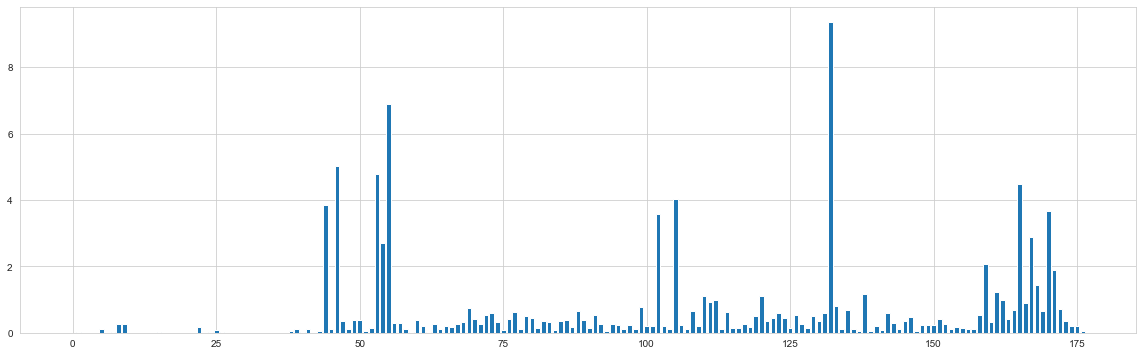

In [45]:
bold("**catboost特征重要性**")
print("feature_ len", len(train_features))
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (20,6)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
# plt.xticks(range(len(train_features)), train_features, rotation=-90, fontsize=20)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.0]

print("*" * 100)
print("\n\n catboost 重要性 > 0.0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

In [43]:
# 上面重要性> 0.0的特特征训练
train_features = ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_jet_px_sum', 'event_id_mean_jet_energy_std', 'event_id_jet_px_mean', 'event_id_x/z_std', 'event_id_x/y_std', 'event_id_mean_jet_energy_log1p_mean', 'event_id_mean_jet_mass_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_energy_mass_std', 'event_id_mean_jet_energy_log1p_std', 'event_id_mean_jet_mass_std', 'event_id_z_mass_std', 'event_id_energy_mass_log1p_mean', 'event_id_abs_mean', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_energy_mass_log1p_std', 'event_id_abs_std', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_sum', 'event_id_y2_std', 'event_id_x_mass_sum', 'event_id_y*z_std', 'event_id_y_mass_std', 'event_id_jet_energy_log1p_std', 'event_id_mean_jet_energy_log1p_sum', 'event_id_mean_jet_mass_sum', 'event_id_y/z_std', 'event_id_x_mass_mean', 'event_id_x+z_sum', 'event_id_x_energy_std', 'event_id_x_energy_log1p_sum', 'event_id_x-z_sum', 'event_id_z2_std', 'event_id_x+z_mean', 'event_id_y-z_sum', 'event_id_x-z_mean', 'event_id_y_energy_std', 'event_id_y+z_mean', 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_energy_mass_mean', 'event_id_z_energy_log1p_mean', 'event_id_x_mass_log1p_sum', 'event_id_z_energy_std', 'event_id_y-z_mean', 'event_id_y2_sum', 'event_id_energy_mass_log1p_sum', 'event_id_z2_mean', 'event_id_x_energy_sum', 'event_id_jet_energy_std', 'event_id_x_energy_mean', 'event_id_y_energy_log1p_sum', 'event_id_jet_py_mean', 'event_id_x+y_sum', 'event_id_jet_py_sum', 'event_id_number_of_particles_in_this_jet_log1p_sum', 'event_id_z2_sum', 'event_id_mean_jet_mass_log1p_mean', 'event_id_x+y_mean', 'event_id_x-y_sum', 'event_id_y+z_sum', 'event_id_z_energy_sum', 'event_id_jet_mass_std', 'event_id_energy_mass_sum', 'event_id_x-y_mean', 'event_id_y_energy_sum', 'event_id_jet_pz_sum', 'event_id_mean_jet_mass_log1p_sum', 'event_id_jet_mass_mean', 'event_id_x_mass_log1p_mean', 'y2', 'event_id_y2_mean', 'event_id_z_energy_log1p_sum', 'z2', 'event_id_jet_mass_log1p_std', 'event_id_x*z_mean', 'event_id_energy_std', 'event_id_x*y_sum', 'event_id_x2_sum', 'event_id_x*z_sum', 'event_id_x_mass_log1p_std', 'event_id_y_energy_log1p_mean', 'event_id_jet_pz_mean', 'event_id_y_mass_log1p_mean', 'event_id_x/z_sum', 'event_id_y/z_sum', 'event_id_jet_energy_sum', 'event_id_x*y_mean', 'event_id_x/y_mean', 'event_id_x_energy_log1p_mean', 'event_id_x2_std', 'event_id_x/y_sum', 'event_id_mean_jet_mass_log1p_std', 'event_id_x2_mean', 'event_id_y_mass_mean', 'event_id_jet_px_std', 'event_id_y_mass_log1p_sum', 'event_id_y*z_sum', 'abs', 'event_id_jet_mass_log1p_mean', 'event_id_y_mass_log1p_std', 'event_id_y_energy_mean', 'event_id_jet_mass_sum', 'event_id_z_energy_mean', 'event_id_y*z_mean', 'energy_mass_log1p', 'event_id_jet_mass_log1p_sum', 'event_id_jet_py_std', 'event_id_jet_energy_log1p_sum', 'event_id_x+z_std', 'event_id_x-z_std', 'mean_jet_mass', 'event_id_y+z_std', 'event_id_z_mass_log1p_mean', 'event_id_x/z_mean', 'event_id_jet_energy_log1p_mean', 'event_id_y-z_std', 'event_id_energy_sum', 'event_id_z_mass_log1p_sum', 'number_of_particles_in_this_jet', 'event_id_y/z_mean', 'event_id_y_energy_log1p_std', 'event_id_x-y_std', 'event_id_y_mass_sum', 'number_of_particles_in_this_jet_log1p', 'event_id_z_mass_log1p_std', 'event_id_x*z_std', 'event_id_x_energy_log1p_std', 'event_id_jet_pz_std', 'event_id_z_mass_mean', 'event_id_x+y_std', 'event_id_x*y_std', 'event_id_z_mass_sum', 'event_id_z_energy_log1p_std', 'event_id_jet_energy_mean', 'mean_jet_mass_log1p', 'event_jet_num', 'energy_mass', 'mean_jet_energy', 'event_id_energy_mean', 'x2', 'x_energy', 'y-z', 'mean_jet_energy_log1p', 'jet_mass_log1p', 'jet_mass', 'y+z', 'jet_energy_log1p', 'x_mass_log1p', 'jet_energy', 'energy']

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm
    
folds = 5
seed = 2019

kf = KFold(n_splits=folds) # 0.701343902176307

# kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)  # 0.701307431068488
results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
  
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=2000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.02, 
        max_depth=8, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))
 
    results += cat_model.predict_proba(test[train_features])
     
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1223-02.csv', index=False)
# 特征筛选
# 0.701307431068488 比上次下降了几个万分点
# 使用KFOLD





0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5169516	test: 0.5138314	best: 0.5138314 (0)	total: 69ms	remaining: 2m 17s
200:	learn: 0.5604411	test: 0.5575798	best: 0.5575798 (200)	total: 10.4s	remaining: 1m 33s
400:	learn: 0.5697520	test: 0.5660325	best: 0.5660325 (400)	total: 20.7s	remaining: 1m 22s
600:	learn: 0.5757830	test: 0.5708009	best: 0.5708009 (600)	total: 30.5s	remaining: 1m 10s
800:	learn: 0.5807949	test: 0.5746350	best: 0.5746747 (799)	total: 40.4s	remaining: 1m
1000:	learn: 0.5857374	test: 0.5780196	best: 0.5780857 (999)	total: 50.3s	remaining: 50.2s
1200:	learn: 0.5905355	test: 0.5818669	best: 0.5818669 (1200)	total: 1m	remaining: 40.3s
1400:	learn: 0.5951529	test: 0.5856217	best: 0.5856217 (1398)	total: 1m 10s	remaining: 30.3s
1600:	learn: 0.5993749	test: 0.5884686	best: 0.5884686 (1600)	total: 1m 20s	remaining: 20.2s
1800:	learn: 0.6036232	test: 0.5915623	best: 0.5915976 (1798)	total: 1m 31s	remaining: 10.1s
1999:	learn: 0.607





1it [01:49, 109.23s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5164448	test: 0.5171763	best: 0.5171763 (0)	total: 62ms	remaining: 2m 3s
200:	learn: 0.5599134	test: 0.5600962	best: 0.5600962 (200)	total: 10.4s	remaining: 1m 32s
400:	learn: 0.5693069	test: 0.5681875	best: 0.5681875 (400)	total: 20.5s	remaining: 1m 21s
600:	learn: 0.5755131	test: 0.5733525	best: 0.5733525 (600)	total: 30.7s	remaining: 1m 11s
800:	learn: 0.5805767	test: 0.5770853	best: 0.5770853 (800)	total: 41s	remaining: 1m 1s
1000:	learn: 0.5853473	test: 0.5808489	best: 0.5808489 (1000)	total: 51.4s	remaining: 51.3s
1200:	learn: 0.5897720	test: 0.5842335	best: 0.5842335 (1200)	total: 1m 2s	remaining: 41.3s
1400:	learn: 0.5942154	test: 0.5872523	best: 0.5872611 (1398)	total: 1m 12s	remaining: 31.1s
1600:	learn: 0.5985342	test: 0.5901917	best: 0.5901917 (1600)	total: 1m 23s	remaining: 20.7s
1800:	learn: 0.6028454	test: 0.5934221	best: 0.5934618 (1798)	total: 1m 33s	remaining: 10.3s
1999:	learn: 0





2it [03:40, 109.80s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5166861	test: 0.5165594	best: 0.5165594 (0)	total: 67.3ms	remaining: 2m 14s
200:	learn: 0.5599519	test: 0.5587521	best: 0.5587521 (200)	total: 10.5s	remaining: 1m 34s
400:	learn: 0.5695890	test: 0.5675353	best: 0.5675485 (398)	total: 20.4s	remaining: 1m 21s
600:	learn: 0.5753985	test: 0.5720877	best: 0.5720877 (600)	total: 30.3s	remaining: 1m 10s
800:	learn: 0.5805117	test: 0.5763097	best: 0.5763097 (800)	total: 40.1s	remaining: 1m
1000:	learn: 0.5853506	test: 0.5800071	best: 0.5800071 (1000)	total: 50.3s	remaining: 50.1s
1200:	learn: 0.5901168	test: 0.5835283	best: 0.5835944 (1190)	total: 1m	remaining: 40.1s
1400:	learn: 0.5946010	test: 0.5867983	best: 0.5867983 (1400)	total: 1m 10s	remaining: 30s
1600:	learn: 0.5988559	test: 0.5894029	best: 0.5894293 (1599)	total: 1m 20s	remaining: 20s
1800:	learn: 0.6034293	test: 0.5928580	best: 0.5929197 (1799)	total: 1m 30s	remaining: 9.98s
1999:	learn: 0.6077





3it [05:28, 109.30s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5162795	test: 0.5175642	best: 0.5175642 (0)	total: 61.1ms	remaining: 2m 2s
200:	learn: 0.5594870	test: 0.5603959	best: 0.5603959 (200)	total: 10.5s	remaining: 1m 34s
400:	learn: 0.5689742	test: 0.5686855	best: 0.5687648 (399)	total: 20.5s	remaining: 1m 21s
600:	learn: 0.5751561	test: 0.5736699	best: 0.5736699 (599)	total: 30.4s	remaining: 1m 10s
800:	learn: 0.5801966	test: 0.5772616	best: 0.5772616 (800)	total: 40.3s	remaining: 1m
1000:	learn: 0.5849265	test: 0.5806814	best: 0.5806814 (999)	total: 50.2s	remaining: 50.1s
1200:	learn: 0.5896089	test: 0.5843701	best: 0.5843701 (1200)	total: 1m	remaining: 40.1s
1400:	learn: 0.5941239	test: 0.5878252	best: 0.5878296 (1398)	total: 1m 10s	remaining: 30s
1600:	learn: 0.5982621	test: 0.5909409	best: 0.5909409 (1600)	total: 1m 20s	remaining: 20s
1800:	learn: 0.6025876	test: 0.5942109	best: 0.5942109 (1800)	total: 1m 30s	remaining: 10s
1999:	learn: 0.6068062	





4it [07:16, 109.01s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5168888	test: 0.5160085	best: 0.5160085 (0)	total: 62.2ms	remaining: 2m 4s
200:	learn: 0.5602560	test: 0.5577517	best: 0.5577517 (200)	total: 10.3s	remaining: 1m 32s
400:	learn: 0.5695493	test: 0.5659884	best: 0.5659884 (400)	total: 20.2s	remaining: 1m 20s
600:	learn: 0.5757940	test: 0.5712284	best: 0.5712284 (600)	total: 30.2s	remaining: 1m 10s
800:	learn: 0.5808202	test: 0.5752343	best: 0.5752343 (799)	total: 40.2s	remaining: 1m
1000:	learn: 0.5856074	test: 0.5787467	best: 0.5788040 (997)	total: 50.2s	remaining: 50.1s
1200:	learn: 0.5901146	test: 0.5817788	best: 0.5817788 (1200)	total: 1m	remaining: 40.4s
1400:	learn: 0.5947012	test: 0.5852383	best: 0.5852383 (1400)	total: 1m 11s	remaining: 30.4s
1600:	learn: 0.5991171	test: 0.5888124	best: 0.5888124 (1600)	total: 1m 21s	remaining: 20.2s
1800:	learn: 0.6034029	test: 0.5919105	best: 0.5919722 (1792)	total: 1m 31s	remaining: 10.1s
1999:	learn: 0.60





5it [09:06, 109.29s/it]


**catboost特征重要性**

feature_ len 154
[1.12786866e+01 7.65751904e+00 5.84692572e+00 4.91274771e+00
 4.83354854e+00 5.14266044e+00 4.40644867e+00 3.59635161e+00
 3.85057549e+00 3.32920649e+00 2.89950131e+00 2.27367660e+00
 1.95127821e+00 1.32166997e+00 1.17038760e+00 1.08873563e+00
 1.27294339e+00 9.56722336e-01 8.30550639e-01 8.48413069e-01
 9.61399684e-01 9.59272319e-01 7.67189391e-01 6.49340221e-01
 5.27542706e-01 8.30977828e-01 6.09014596e-01 5.98822361e-01
 6.72486884e-01 6.17195969e-01 5.87637624e-01 5.39087986e-01
 5.28162871e-01 4.30772204e-01 4.76924925e-01 5.09281829e-01
 3.67718698e-01 6.64322356e-01 3.53529246e-01 5.58941879e-01
 3.23327932e-01 5.12646576e-01 6.21770727e-01 5.29225998e-01
 5.14332083e-01 2.12545933e-01 3.42493964e-01 5.25058103e-01
 3.97147213e-01 3.94173094e-01 3.84499799e-01 2.95488278e-01
 2.50287384e-01 2.51648845e-01 2.18139052e-01 3.27773542e-01
 3.31312451e-01 3.16265715e-01 1.79609529e-01 3.31959823e-01
 3.44141279e-01 4.20546531e-01 2.39959968e-01 3.00069916e-01
 2.5214

[('event_id_x_mass_std', 11.278686640613023), ('event_id_number_of_particles_in_this_jet_sum', 7.657519044563241), ('event_id_number_of_particles_in_this_jet_mean', 5.846925716204055), ('event_id_jet_px_mean', 5.14266043969008), ('event_id_jet_px_sum', 4.9127477051330235), ('event_id_mean_jet_energy_std', 4.833548537560294), ('event_id_x/z_std', 4.406448666516788), ('event_id_mean_jet_energy_log1p_mean', 3.8505754945781248), ('event_id_x/y_std', 3.596351605594293), ('event_id_mean_jet_mass_mean', 3.329206494128985), ('event_id_number_of_particles_in_this_jet_std', 2.899501306909575), ('event_id_energy_mass_std', 2.2736765982672336), ('event_id_mean_jet_energy_log1p_std', 1.9512782142012155), ('event_id_mean_jet_mass_std', 1.3216699685091908), ('event_id_abs_mean', 1.2729433886485013), ('event_id_z_mass_std', 1.170387600401263), ('event_id_energy_mass_log1p_mean', 1.0887356283439789), ('event_id_abs_sum', 0.9613996841376627), ('event_id_mean_jet_energy_mean', 0.9592723192551025), ('even

 catboost 重要性 > 0.0 特征类别： 144 ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_jet_px_mean', 'event_id_jet_px_sum', 'event_id_mean_jet_energy_std', 'event_id_x/z_std', 'event_id_mean_jet_energy_log1p_mean', 'event_id_x/y_std', 'event_id_mean_jet_mass_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_energy_mass_std', 'event_id_mean_jet_energy_log1p_std', 'event_id_mean_jet_mass_std', 'event_id_abs_mean', 'event_id_z_mass_std', 'event_id_energy_mass_log1p_mean', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_abs_std', 'event_id_y*z_std', 'event_id_energy_mass_log1p_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_energy_log1p_sum', 'event_id_x+z_mean', 'event_id_y2_std', 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_mean_jet_mass_sum', 'event_id_y_mass_std', 'event_id_jet_energy_log1p_std', 'even

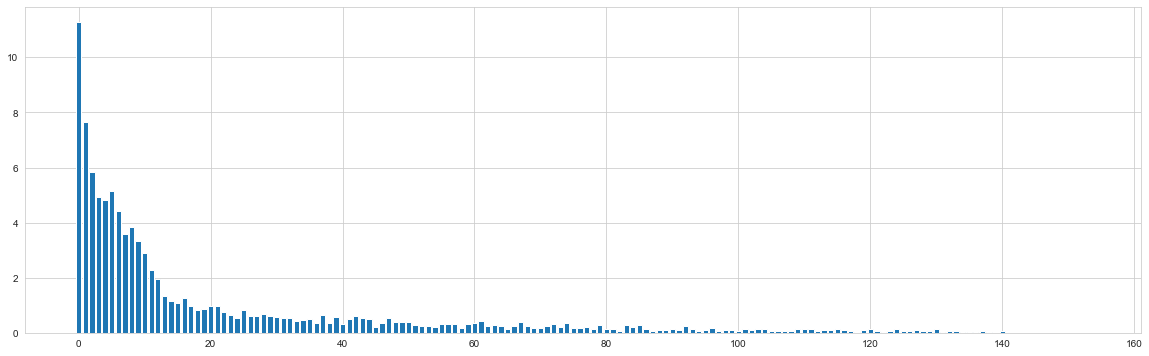

In [39]:
bold("**catboost特征重要性**")
print("feature_ len", len(train_features))
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (20,6)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
# plt.xticks(range(len(train_features)), train_features, rotation=-90, fontsize=20)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.0]

print("*" * 100)
print("\n\n catboost 重要性 > 0.0 特征类别：", len(feature_import_usefull),  feature_import_usefull)